In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

import pmdarima as pm
import statsmodels.tsa.api as tsa

### get data

In [3]:
# print(os.getcwd())
# os.system(f'python ./1_data_prepro.py')

os.chdir("C:/2023_11-PTSFC")
from data_prepro import get_dax_data, get_dax_returns

print(f"cwd = {os.getcwd()}")

if (not os.path.isfile("./data/2000-01-01_2023-11-01_dax_prices.csv")) :
    print("Downloading historic DAX data ... from 2000-01-01 to 2023-11-01")
    get_dax_data()

start = "2023-11-01"
today = datetime.today().strftime("%Y-%m-%d")
get_dax_data(start, today)

# get returns from combined historirc and recent data
returns_df = get_dax_returns("2000-01-01_2023-11-01_dax_prices", f"{start}_{today}_dax_prices")

# save returns to csv file
fname = f"2000-01-01_{today}_dax_returns"
returns_df.to_csv(f"./data/{fname}.csv")

cwd = C:\2023_11-PTSFC


### train test split

In [65]:
today = datetime.today().strftime("%Y-%m-%d")
fname = f"2000-01-01_{today}_dax_returns.csv"

# Load data
ret_df = pd.read_csv(f"./data/{fname}", index_col=0)
ret_df.index = pd.to_datetime(ret_df.index)

ignore_first = 4000
ret_df = ret_df.iloc[ignore_first:]

# print(ret_df.shape)
# ret_df.head()

# train test split
split_pt = 0.99
train_data = ret_df[:int(len(ret_df) * split_pt)]
test_data = ret_df[int(len(ret_df) * split_pt):]

print(f"train {train_data.shape}")
print(train_data.head())
print(f"test {test_data.shape}")
print(test_data.head())

train (2074, 5)
                ret1      ret2      ret3      ret4      ret5
2015-10-07  0.680016  1.573031  4.275814  4.735573  3.158150
2015-10-08  0.227114  0.907130  1.800145  4.502928  4.962687
2015-10-09  1.030681  1.257795  1.937811  2.830826  5.533609
2015-10-12  0.229818  1.260499  1.487613  2.167629  3.060644
2015-10-13 -0.863512 -0.633694  0.396987  0.624101  1.304117
test (21, 5)
                ret1      ret2      ret3      ret4      ret5
2023-12-07 -0.164932  0.578257  1.357605  1.401750  2.518433
2023-12-08  0.780102  0.615170  1.358360  2.137707  2.181852
2023-12-11  0.209867  0.989969  0.825037  1.568227  2.347574
2023-12-12 -0.016015  0.193852  0.973954  0.809022  1.552211
2023-12-13 -0.153106 -0.169121  0.040746  0.820848  0.655916


### ARMA autoarima

In [67]:
max_p_q = 10
arma_models = {}

for i, ret_horizon in enumerate(train_data.columns):
    
    print('= '*15)
    print(f"start {ret_horizon}")

    # fit ARIMA models using pmdarima to find best order
    arma_models[ret_horizon] = pm.auto_arima(train_data[ret_horizon], start_p=1, start_q=1,
                                             max_p=max_p_q, max_q=max_p_q, error_action='ignore')
    
    # print order of best model
    print(f"{ret_horizon} : {arma_models[ret_horizon].order}")
    # also print coefficients
    print(f"coefficients : {arma_models[ret_horizon].params()}")

= = = = = = = = = = = = = = = 
start ret1
ret1 : (0, 0, 0)
= = = = = = = = = = = = = = = 
start ret2
ret2 : (10, 0, 0)
= = = = = = = = = = = = = = = 
start ret3
ret3 : (10, 0, 1)
= = = = = = = = = = = = = = = 
start ret4
ret4 : (10, 0, 0)
= = = = = = = = = = = = = = = 
start ret5
ret5 : (8, 0, 3)


### ARMA rolling fcast

In [75]:
arma_models_eval = arma_models.copy()
test_data_arma_preds = test_data.copy()

print(f"start rolling forecast in test_data for arma models")

for ret_horizon, model in arma_models_eval.items():

    # for each row in test data predict one step ahead return
    # and update model with new data
    preds = np.zeros(len(test_data))
    conf_int = np.zeros((len(test_data), 2))

    for idx, (timestamp, test_data_row) in enumerate(test_data.iterrows()):

        print(f"{idx+1}/{len(test_data)}", end="\r")
        res = model.predict(n_periods=1, return_conf_int=True)

        try: preds[idx] = res[0][0] 
        except: 
            print('enter except')
            preds[idx] = res[0].values[0]
        conf_int[idx] = res[1][0]
        
        # print old coefficients
        # print(model.params())

        model.update(test_data_row, error_action='ignore')#
            # Internally, this calls fit again 
            # using the OLD model parameters as the starting parameters for the new model’s MLE computation.
        
        # print new coefficients
        # print(model.params())

    test_data_arma_preds[f"{ret_horizon}_arma_pred"] = preds
    test_data_arma_preds[f"{ret_horizon}_lower_CI"] = conf_int[:, 0]
    test_data_arma_preds[f"{ret_horizon}_upper_CI"] = conf_int[:, 1]

    print('- '*15)
    print(f"{ret_horizon} done")

start rolling forecast in test_data for arma models
- - - - - - - - - - - - - - - 
ret1 done
- - - - - - - - - - - - - - - 
ret2 done
- - - - - - - - - - - - - - - 
ret3 done
- - - - - - - - - - - - - - - 
ret4 done
enter except


c:\Users\ytl_c\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ytl_c\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- - - - - - - - - - - - - - - 
ret5 done


### Baseline Pred

In [92]:
test_data

,ret1,ret2,ret3,ret4,ret5
2023-12-07,-0.164932,0.578257,1.357605,1.401750,2.518433
2023-12-08,0.780102,0.615170,1.358360,2.137707,2.181852
2023-12-11,0.209867,0.989969,0.825037,1.568227,2.347574
2023-12-12,-0.016015,0.193852,0.973954,0.809022,1.552211
2023-12-13,-0.153106,-0.169121,0.040746,0.820848,0.655916
2023-12-14,-0.082464,-0.235570,-0.251585,-0.041718,0.738384
2023-12-15,-0.004722,-0.087186,-0.240292,-0.256307,-0.046440
2023-12-18,-0.604090,-0.608812,-0.691276,-0.844382,-0.860397
2023-12-19,0.562118,-0.041971,-0.046693,-0.129157,-0.282263
2023-12-20,-0.067863,0.494256,-0.109834,-0.114556,-0.197020


In [ ]:
last_t = 100
tau = [.025, .25, .5, .75, .975]

test_data_baseline_preds = test_data.copy()

for idx, (timestamp, test_data_row) in enumerate(test_data.iterrows()):

    print(f"{idx+1}/{len(test_data)}", end="\r")

    pred_baseline = np.zeros((5,5))

    for i in range(5):
        ret_str = "ret"+str(i+1)
        pred_baseline[i,:] = np.quantile(train_data[ret_str].iloc[-last_t:], q=tau)

    # transpose
    pred_baseline = pred_baseline.T

pred_baseline

array([[-1.35278194, -0.3956857 ,  0.09366636,  0.51341485,  1.58224178],
       [-1.98086968, -0.59877329, -0.02796215,  0.82599179,  2.19909831],
       [-2.59923077, -0.91919925,  0.14983403,  0.969235  ,  2.68951582],
       [-3.02994863, -0.99479203,  0.20181307,  1.09734255,  3.11273185],
       [-3.12142689, -1.06385785,  0.04563079,  1.33641706,  3.35431255]])

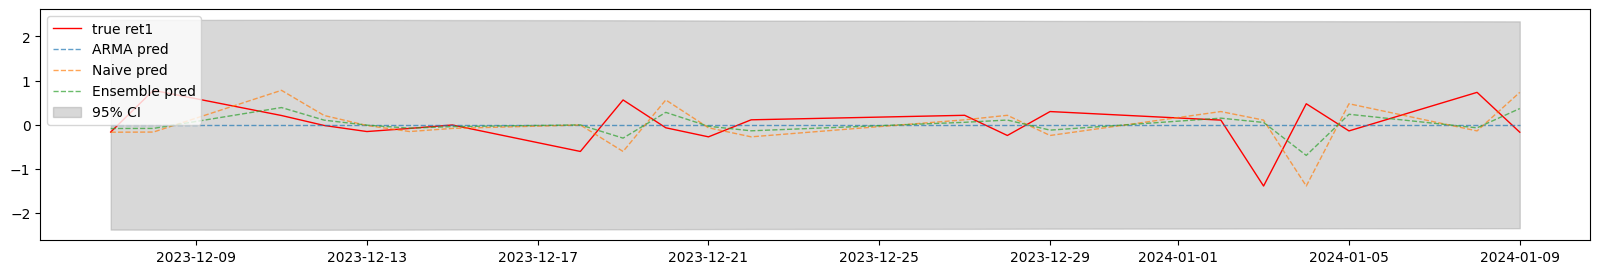

,ret_horizon,model,aic,bic,loglike,MSE,MAE,MAPE,SMAPE
0,ret1,"arma(0,0,0)",7293.201774,7298.935457,-3645.601000,0.210721,0.323666,1.000000,2.000000
1,ret1,naive,-,-,-,0.562325,0.574126,3.560508,1.615770
2,ret1,ensemble,-,-,-,0.333843,0.430118,2.095631,1.608138


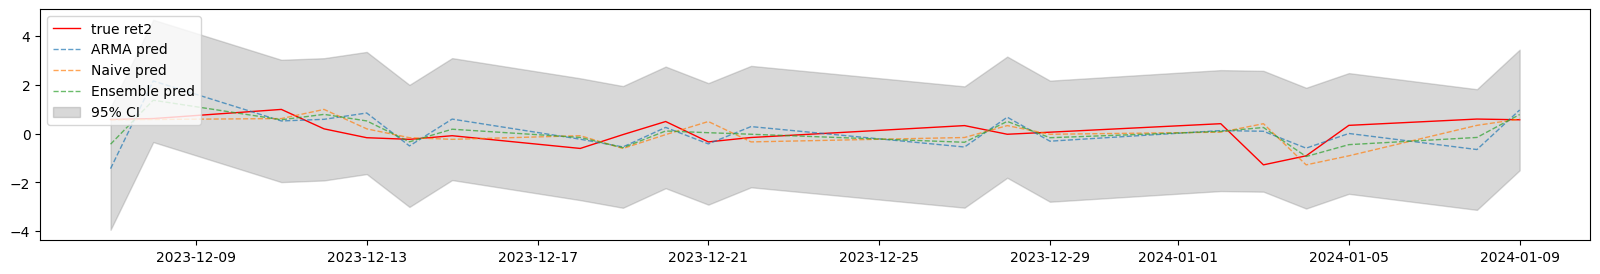

,ret_horizon,model,aic,bic,loglike,MSE,MAE,MAPE,SMAPE
0,ret2,"arma(10,0,0)",7565.447638,7628.518157,-3771.724000,0.682625,0.663629,3.803998,1.376442
1,ret2,naive,-,-,-,0.363932,0.443116,2.393402,1.216706
2,ret2,ensemble,-,-,-,0.379009,0.514017,2.920262,1.433842


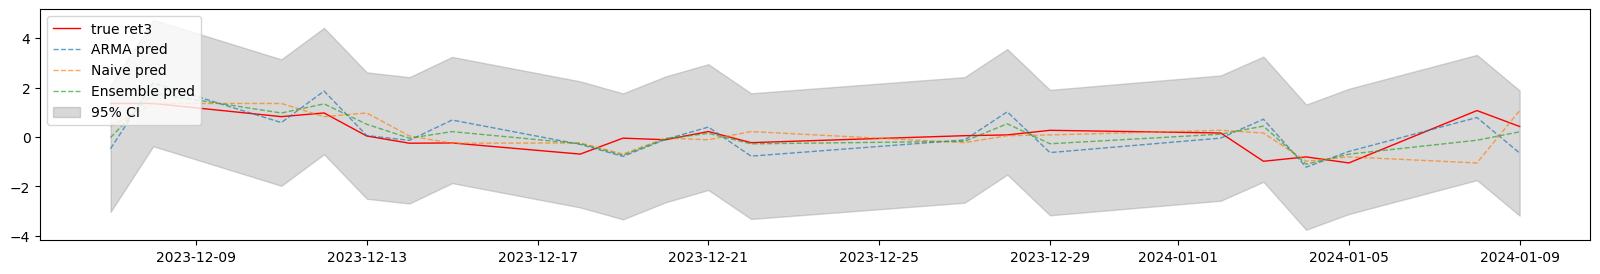

,ret_horizon,model,aic,bic,loglike,MSE,MAE,MAPE,SMAPE
0,ret3,"arma(10,0,1)",7678.229246,7747.033448,-3827.115000,0.622263,0.613273,2.475186,1.131940
1,ret3,naive,-,-,-,0.452687,0.463348,2.674473,1.067704
2,ret3,ensemble,-,-,-,0.364872,0.451849,2.297755,1.080891


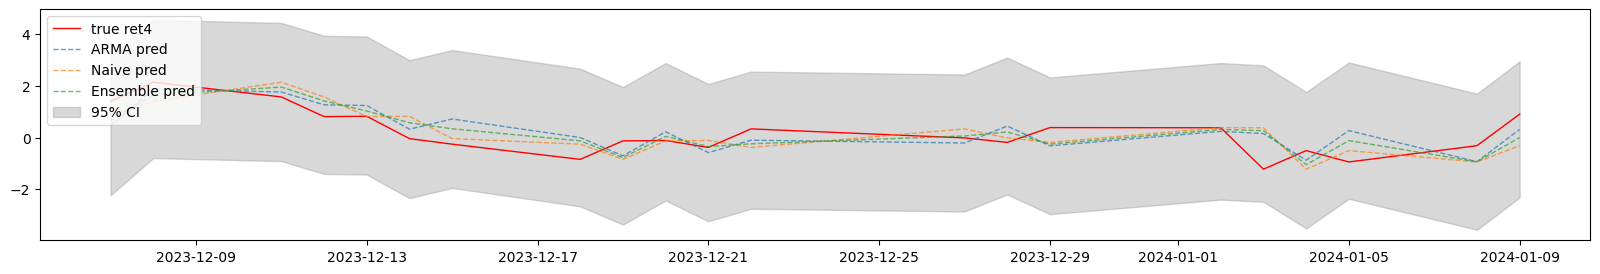

,ret_horizon,model,aic,bic,loglike,MSE,MAE,MAPE,SMAPE
0,ret4,"arma(10,0,0)",7711.016447,7773.892614,-3844.508000,0.431123,0.564246,2.392008,1.267539
1,ret4,naive,-,-,-,0.455058,0.555316,3.170128,1.102852
2,ret4,ensemble,-,-,-,0.396675,0.539215,2.073220,1.256096


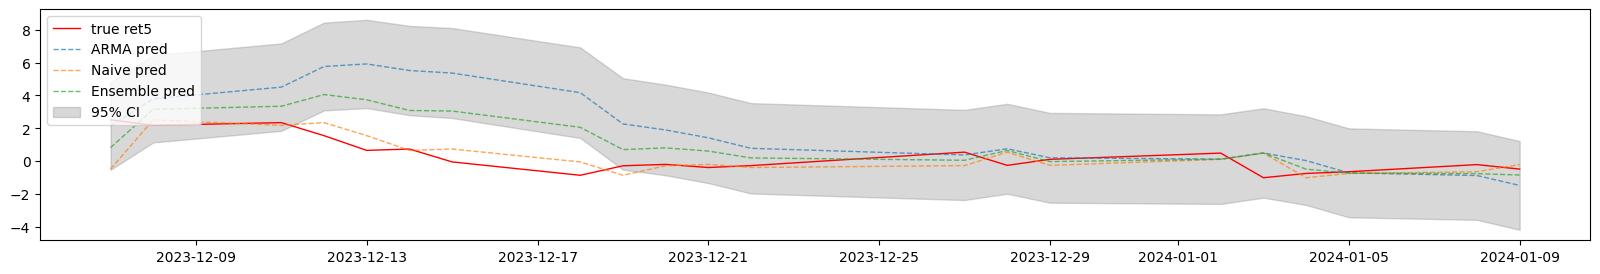

,ret_horizon,model,aic,bic,loglike,MSE,MAE,MAPE,SMAPE
0,ret5,"arma(8,0,3)",7606.683846,7674.923302,-3791.342000,7.199235,2.001520,8.731953,1.338693
1,ret5,naive,-,-,-,0.783608,0.609080,1.809576,1.011310
2,ret5,ensemble,-,-,-,2.449550,1.226392,5.039845,1.349854


In [80]:
# results_df = pd.DataFrame()

for ret_horizon in test_data.columns:

    # Actual realized values
    test_actual = test_data[ret_horizon].values

    # ARMA predictions
    preds_arma = test_data_arma_preds[f"{ret_horizon}_arma_pred"]
    upper_ci = test_data_arma_preds[f"{ret_horizon}_upper_CI"]
    lower_ci = test_data_arma_preds[f"{ret_horizon}_lower_CI"]
    
    # Naive forecast using the last timestep value
    preds_naive = np.roll(test_actual, 1)
    # Ensemble forecast by averaging ARMA and Naive forecasts
    preds_ensemble = (preds_arma + preds_naive) / 2
    
    # - - - - - - - - - - - -
    # Plotting ARMA and Naive forecasts
    plt.figure(figsize=(20, 3))

    plt.plot(test_data.index, test_actual, lw=1, color='red', label=f'true {ret_horizon}')
    plt.plot(test_data.index, preds_arma, lw=1, alpha=0.7, ls='--', label='ARMA pred')
    plt.plot(test_data.index, preds_naive, lw=1, alpha=0.7, ls='--', label='Naive pred')
    plt.plot(test_data.index, preds_ensemble, lw=1, alpha=0.7, ls='--', label='Ensemble pred')

    plt.fill_between(test_data.index, upper_ci, lower_ci, 
                    color='gray', alpha=0.3, lw=1, label=f'95% CI')

    plt.legend(loc='upper left')
    plt.show()
    # - - - - - - - - - - - -

    arma_model_dict = arma_models_eval[ret_horizon].to_dict()
    p, d, q = arma_model_dict['order']
    aic = arma_model_dict['aic']
    bic = arma_model_dict['bic']
    loglike = float(arma_models_eval[ret_horizon].summary().as_text().split("Log Likelihood")[1].split("\n")[0].replace(" ", ""))

    # Error calculation for ARMA forecast
    error_arma = test_actual - preds_arma
    mse_arma = np.mean(error_arma**2)
    mae_arma = np.mean(np.abs(error_arma))
    mape_arma = np.mean(np.abs(error_arma) / np.abs(test_actual))
    smape_arma = np.mean(2 * np.abs(error_arma) / (np.abs(test_actual) + np.abs(preds_arma)))

    # Error calculation for Naive forecast
    error_naive = test_actual - preds_naive
    mse_naive = np.mean(error_naive**2)
    mae_naive = np.mean(np.abs(error_naive))
    mape_naive = np.mean(np.abs(error_naive) / np.abs(test_actual))
    smape_naive = np.mean(2 * np.abs(error_naive) / (np.abs(test_actual) + np.abs(preds_naive)))

    # Error calculation for Ensemble forecast
    error_ensemble = test_actual - preds_ensemble
    mse_ensemble = np.mean(error_ensemble**2)
    mae_ensemble = np.mean(np.abs(error_ensemble))
    mape_ensemble = np.mean(np.abs(error_ensemble) / np.abs(test_actual))
    smape_ensemble = np.mean(2 * np.abs(error_ensemble) / (np.abs(test_actual) + np.abs(preds_ensemble)))

    # Save results in dataframes
    arma_results = pd.DataFrame({
        'ret_horizon': ret_horizon,
        'model': f'arma({p},{d},{q})',
        'aic': aic,
        'bic': bic,
        'loglike': loglike,
        'MSE': mse_arma,
        'MAE': mae_arma,
        'MAPE': mape_arma,
        'SMAPE': smape_arma,
    }, index=[0])

    # Save results in dataframes
    naive_results = pd.DataFrame({
        'ret_horizon': ret_horizon,
        'model': 'naive',
        'aic': '-',
        'bic': '-',
        'loglike': '-',
        'MSE': mse_naive,
        'MAE': mae_naive,
        'MAPE': mape_naive,
        'SMAPE': smape_naive,
    }, index=[0])

    # Save results in dataframes
    ensemble_results = pd.DataFrame({
        'ret_horizon': ret_horizon,
        'model': 'ensemble',
        'aic': '-',
        'bic': '-',
        'loglike': '-',
        'MSE': mse_ensemble,
        'MAE': mae_ensemble,
        'MAPE': mape_ensemble,
        'SMAPE': smape_ensemble,
    }, index=[0])

    # Append to results_df
    results_df = pd.concat([arma_results, naive_results, ensemble_results], ignore_index=True)
    display(results_df.style.highlight_min(subset=['MSE', 'MAE', 'MAPE', 'SMAPE'], axis=0))


### Compare Errors

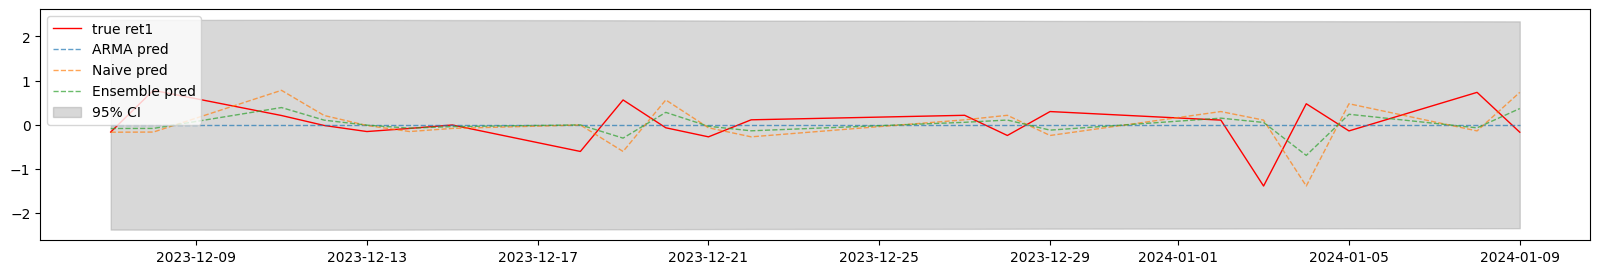

,model_type,MSE,MAE,MAPE,SMAPE
0,arma,0.210721,0.323666,1.000000,2.000000
1,naive,0.562325,0.574126,3.560508,1.615770
2,ensemble,0.333843,0.430118,2.095631,1.608138


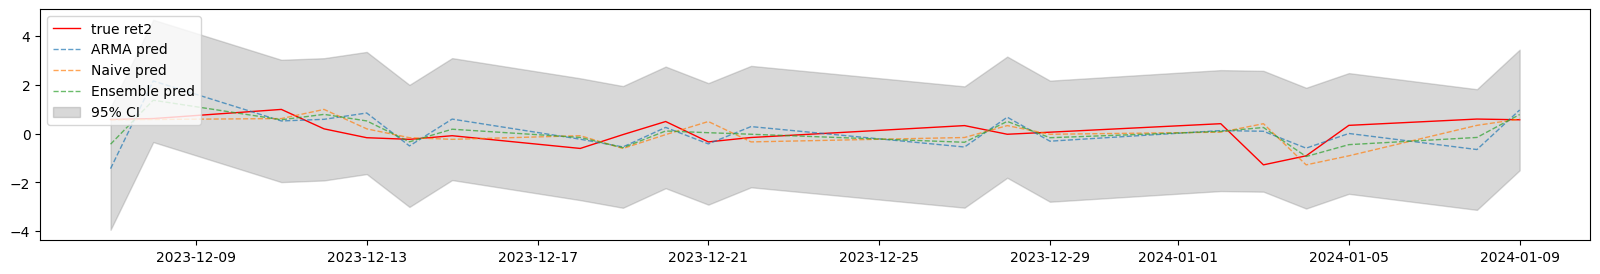

,model_type,MSE,MAE,MAPE,SMAPE
0,arma,0.682625,0.663629,3.803998,1.376442
1,naive,0.363932,0.443116,2.393402,1.216706
2,ensemble,0.379009,0.514017,2.920262,1.433842


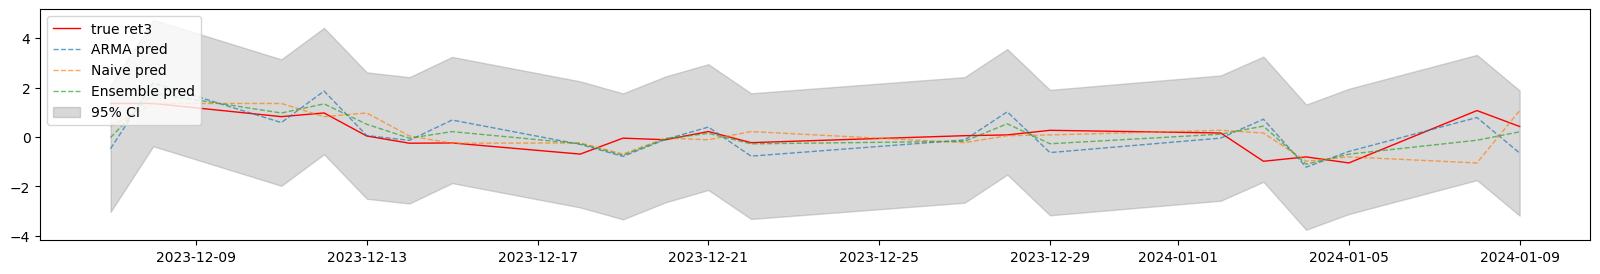

,model_type,MSE,MAE,MAPE,SMAPE
0,arma,0.622263,0.613273,2.475186,1.131940
1,naive,0.452687,0.463348,2.674473,1.067704
2,ensemble,0.364872,0.451849,2.297755,1.080891


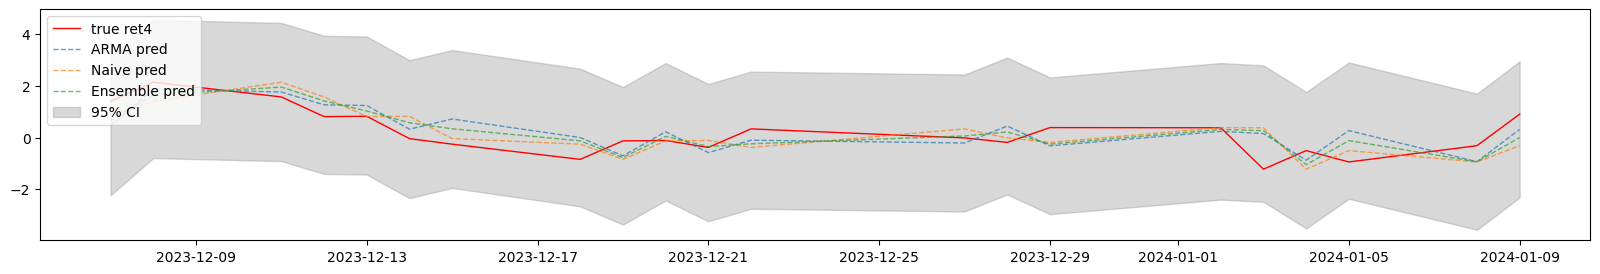

,model_type,MSE,MAE,MAPE,SMAPE
0,arma,0.431123,0.564246,2.392008,1.267539
1,naive,0.455058,0.555316,3.170128,1.102852
2,ensemble,0.396675,0.539215,2.073220,1.256096


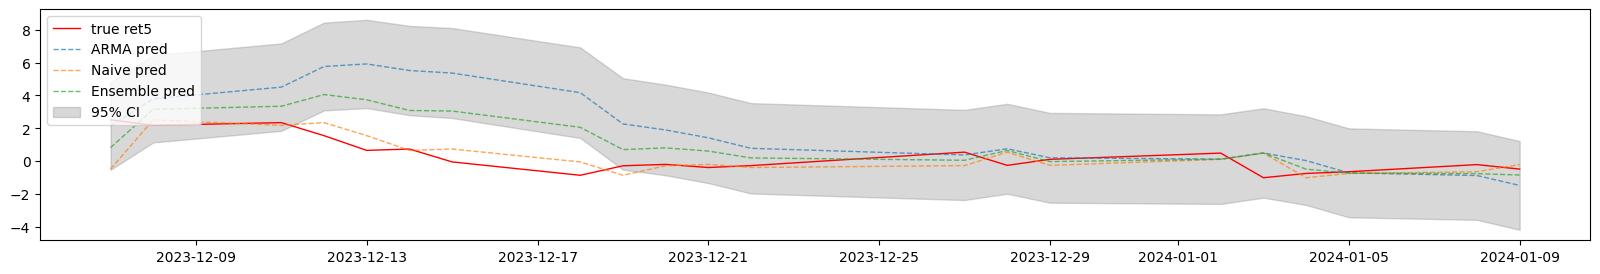

,model_type,MSE,MAE,MAPE,SMAPE
0,arma,7.199235,2.001520,8.731953,1.338693
1,naive,0.783608,0.609080,1.809576,1.011310
2,ensemble,2.449550,1.226392,5.039845,1.349854


In [82]:
def calculate_errors(model_type, test_actual, preds):
    
    error = test_actual - preds
    mse = np.mean(error**2)
    mae = np.mean(np.abs(error))
    mape = np.mean(np.abs(error) / np.abs(test_actual))
    smape = np.mean(2 * np.abs(error) / (np.abs(test_actual) + np.abs(preds)))

    return pd.DataFrame({
        'model_type': model_type,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'SMAPE': smape,
    }, index=[0])

for ret_horizon in test_data.columns:

    # Actual realized values
    test_actual = test_data[ret_horizon].values

    # ARMA predictions
    preds_arma = test_data_arma_preds[f"{ret_horizon}_arma_pred"]
    upper_ci = test_data_arma_preds[f"{ret_horizon}_upper_CI"]
    lower_ci = test_data_arma_preds[f"{ret_horizon}_lower_CI"]
    
    # Naive forecast using the last timestep value
    preds_naive = np.roll(test_actual, 1)
    preds_naive[0] = train_data[ret_horizon].iloc[-1]
    # Ensemble forecast by averaging ARMA and Naive forecasts
    preds_ensemble = (preds_arma + preds_naive) / 2
    # Baseline fcast from PTSFC
    pred_baseline = np.quantile(hist[ret_str].iloc[-last_t:], q=tau)
    
    # - - - - - - - - - - - -
    # Plotting ARMA and Naive forecasts
    plt.figure(figsize=(20, 3))

    plt.plot(test_data.index, test_actual, lw=1, color='red', label=f'true {ret_horizon}')
    plt.plot(test_data.index, preds_arma, lw=1, alpha=0.7, ls='--', label='ARMA pred')
    plt.plot(test_data.index, preds_naive, lw=1, alpha=0.7, ls='--', label='Naive pred')
    plt.plot(test_data.index, preds_ensemble, lw=1, alpha=0.7, ls='--', label='Ensemble pred')

    plt.fill_between(test_data.index, upper_ci, lower_ci, 
                    color='gray', alpha=0.3, lw=1, label=f'95% CI')

    plt.legend(loc='upper left')
    plt.show()
    # - - - - - - - - - - - -

    arma_model_dict = arma_models_eval[ret_horizon].to_dict()
    p, d, q = arma_model_dict['order']
    aic = arma_model_dict['aic']
    bic = arma_model_dict['bic']
    loglike = float(arma_models_eval[ret_horizon].summary().as_text().split("Log Likelihood")[1].split("\n")[0].replace(" ", ""))

    # Calculate errors and create results dataframes
    arma_results = calculate_errors('arma', test_actual, preds_arma)
    naive_results = calculate_errors('naive', test_actual, preds_naive)
    ensemble_results = calculate_errors('ensemble', test_actual, preds_ensemble)

    # Append to results_df
    results_df = pd.concat([arma_results, naive_results, ensemble_results], ignore_index=True)
    display(results_df.style.highlight_min(subset=['MSE', 'MAE', 'MAPE', 'SMAPE'], axis=0))
